In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
img_size = 270
img_crop = 256

In [4]:
# normalization parameters
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

#Applying Transformation
train_transforms = transforms.Compose([transforms.Resize((img_size,img_size)),
                                transforms.CenterCrop(img_crop),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((img_size,img_size)),
                                      transforms.CenterCrop(img_crop),
                                      transforms.ToTensor()])

In [5]:
train_set = torchvision.datasets.ImageFolder('dataset/training_set', transform=train_transforms)
test_set = torchvision.datasets.ImageFolder('dataset/test_set', transform=test_transforms)

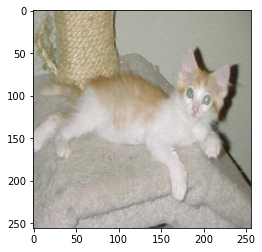

In [6]:
plt.imshow(train_set[9][0].permute(1,2,0))

In [7]:
BATCH_SIZE = 32

In [8]:
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
torch.manual_seed(0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.batch_32 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.batch_64 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.batch_128 = nn.BatchNorm2d(128)

        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.4)

        self.fc1 = nn.Linear(in_features=128*32*32, out_features=64)
        self.batch_fc = nn.BatchNorm1d(64)

        self.out = nn.Linear(in_features=64, out_features=2)

    

    def forward(self, x):

        x = self.conv1(x)
        x = self.batch_32(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.batch_64(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.batch_128(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.dropout(x)

        x = self.fc1(x.view(-1, 128*32*32))
        x = self.batch_fc(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.out(x)
        return x

In [10]:
torch.manual_seed(0)
net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_02): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=131072, out_features=64, bias=True)
  (batch_fc): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)


In [11]:
EPOCHS = 60
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [18]:
def train():
    
    train_loss = []
    test_loss = []

    for epoch in range(EPOCHS):
        running_loss = 0.0
        running_test_loss = 0.0
        correct_predictions = 0.0

        net.train()
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data.view(BATCH_SIZE, 3, img_crop, img_crop))
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.detach().item()

        
        with torch.no_grad():
            net.eval()
            for (data, target) in test_loader:
                data, target = data.to(device), target.to(device)
                output = net(data.view(BATCH_SIZE, 3, img_crop, img_crop))
                loss = criterion(output, target)
                running_test_loss += loss.detach().item()

                index = output.max(dim=1)[1]
                correct_predictions = correct_predictions + (index == target).sum().detach().item()

        avg_train_loss = running_loss / len(train_loader)
        train_loss.append(avg_train_loss)

        avg_test_loss = running_test_loss / len(test_loader)
        test_loss.append(avg_test_loss)

        accuracy = 100*(correct_predictions / (len(test_loader)*BATCH_SIZE))

        print('Epoch {}, Train Loss: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.3f}'.format(epoch+1, avg_train_loss, avg_test_loss, accuracy))

    return train_loss, test_loss

def test():
    running_loss = 0.0
    for (data, target) in test_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data.view(BATCH_SIZE, 3, img_crop, img_crop))
        loss = criterion(output, target)
        running_loss += loss.detach().item()

    loss = running_loss / len(test_loader)
    print('Test Loss: ', loss)
    return loss

In [13]:
train_loss, test_loss = train()

Epoch 1, Train Loss: 0.6240, Test Loss: 0.6693, Test Accuracy: 63.105
Epoch 2, Train Loss: 0.5423, Test Loss: 0.5867, Test Accuracy: 69.052
Epoch 3, Train Loss: 0.4977, Test Loss: 0.5017, Test Accuracy: 74.748
Epoch 4, Train Loss: 0.4655, Test Loss: 0.4928, Test Accuracy: 75.907
Epoch 5, Train Loss: 0.4098, Test Loss: 0.4550, Test Accuracy: 79.889
Epoch 6, Train Loss: 0.3878, Test Loss: 0.4660, Test Accuracy: 79.335
Epoch 7, Train Loss: 0.3617, Test Loss: 0.4429, Test Accuracy: 80.242
Epoch 8, Train Loss: 0.3496, Test Loss: 0.4488, Test Accuracy: 79.385
Epoch 9, Train Loss: 0.3219, Test Loss: 0.4650, Test Accuracy: 79.435
Epoch 10, Train Loss: 0.3069, Test Loss: 0.4926, Test Accuracy: 79.284
Epoch 11, Train Loss: 0.2728, Test Loss: 0.4399, Test Accuracy: 80.897
Epoch 12, Train Loss: 0.2526, Test Loss: 0.4306, Test Accuracy: 81.603
Epoch 13, Train Loss: 0.2451, Test Loss: 0.4642, Test Accuracy: 80.948
Epoch 14, Train Loss: 0.2284, Test Loss: 0.4846, Test Accuracy: 79.385
Epoch 15, Train

In [14]:
torch.save(net, 'models/conv_3_fc_3_lr_0.001.pt')

In [15]:
net = torch.load('models/conv_3_fc_3_lr_0.001.pt')

In [16]:
dataset = transforms.Compose([transforms.Resize((img_size,img_size)),
                                transforms.CenterCrop(img_crop),
                                transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder('dataset/training_set', transform=dataset)

<Figure size 432x288 with 0 Axes>

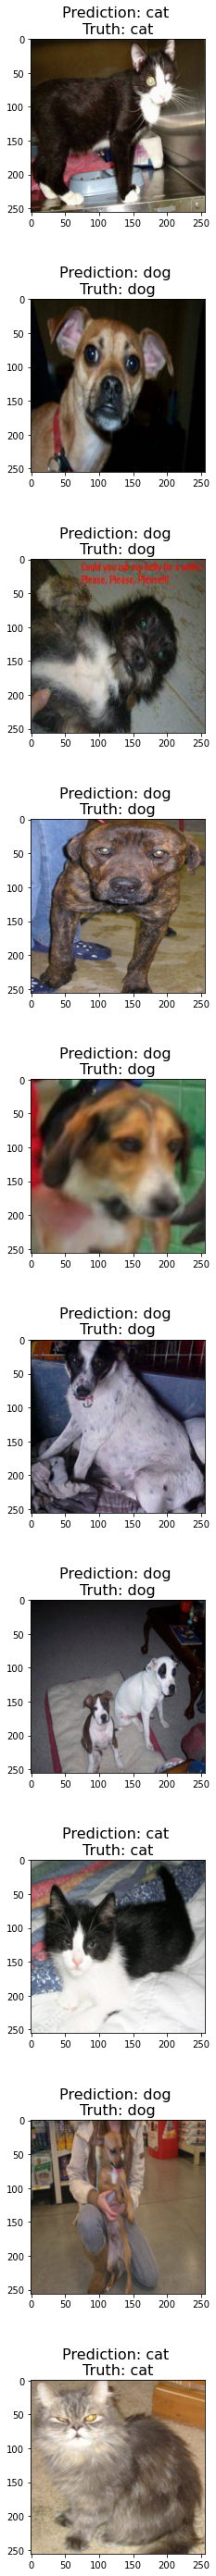

In [17]:
animal = {0: 'cat', 1: 'dog'}

n = 10

plt.figure()
fig, ax = plt.subplots(n, 1, figsize=(50, 50))
fig.subplots_adjust(hspace=0.5)

indices = list(range(8000))
random.shuffle(indices)
indices = indices[:10]

for j, i in enumerate(indices):
    truth_label = dataset[i][1]

    prediction = net(dataset[i][0].view(1, 3, img_crop, img_crop).to(device))
    index = prediction.argmax().item()

    ax[j].set_title('Prediction: {} \nTruth: {}'.format(animal[index], animal[truth_label]), FontSize=16)
    ax[j].imshow(dataset[i][0].permute(1,2,0), cmap='gray_r')
    j = j + 1